In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import seaborn as sn





In [32]:
df = pd.read_csv('TCGA_GBM_LGG_Mutations_clean.csv')
df

,Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,1,1,51.30,2,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,1,38.72,2,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,35.17,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,32.78,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,31.51,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,0,0,77.89,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
853,0,1,85.18,2,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
854,0,0,77.49,2,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
855,0,1,63.33,2,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [33]:
all_inputs = df[df.loc[:, "Gender":].columns.values.tolist()].values

all_labels = df['Grade'].values

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25, random_state=1)

# Generate the same cross validation strategy for all classifiers for better comparison
cross_validation = StratifiedKFold(n_splits=5)

# Classifier/Model Results dictionary
results = {}

In [34]:
Grade = df.pop('Grade')
x_train, x_test, y_train, y_test = train_test_split(df, Grade, test_size=0.25)
RandomForest = RandomForestClassifier()
RandomForest.fit(x_train, y_train)

RandomForestClassifier()

### Function to test the Model / Classifier

In [35]:
def test_model(model, parameters):
    grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=cross_validation, n_jobs=-1)
    grid_result = grid_search.fit(all_inputs, all_labels)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    return grid_result

### Random Forest with Hyperparameterization

In [36]:
parameter_grid = {
    'n_estimators': [10, 20, 30],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

result = test_model(RandomForest, parameter_grid)

results['Random Forest'] = result

Best: 0.878669 using {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 20}
0.847124 (0.016422) with: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
0.841289 (0.009628) with: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
0.844805 (0.015535) with: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}
0.870475 (0.010095) with: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
0.866993 (0.009831) with: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20}
0.861132 (0.014571) with: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 30}
0.872814 (0.013495) with: {'criterion': 'gini', 'max_depth': None,

In [37]:
y_predicted = RandomForest.predict(x_test)
cm = confusion_matrix(y_test, y_predicted)

Text(33.22222222222222, 0.5, 'Truth')

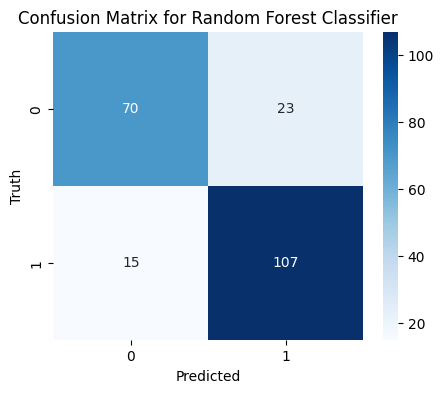

In [38]:
%matplotlib inline
plt.figure(figsize=(5,4))
sn.heatmap(cm, annot=True, cmap='Blues', fmt="d")
plt.title('Confusion Matrix for Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Naives Bayes Classifier with Hyperparameterization

#### Function to test the Model / Classifier

In [39]:
def test_model(model, parameters):
    grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=cross_validation, n_jobs=-1)
    grid_result = grid_search.fit(all_inputs, all_labels)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    return grid_result


##### Gaussian Naives Bayes

In [40]:
GaussianNaivesBayes = GaussianNB()
GaussianNaivesBayes.fit(x_train, y_train)

gnb_param_grid = {
    # There are no hyperparameters to tune for GaussianNB
}

gnb_grid_result = test_model(GaussianNaivesBayes, gnb_param_grid)

results['GaussianNaivesBayes'] = gnb_grid_result

Best: 0.802958 using {}
0.802958 (0.068119) with: {}


Text(33.22222222222222, 0.5, 'Truth')

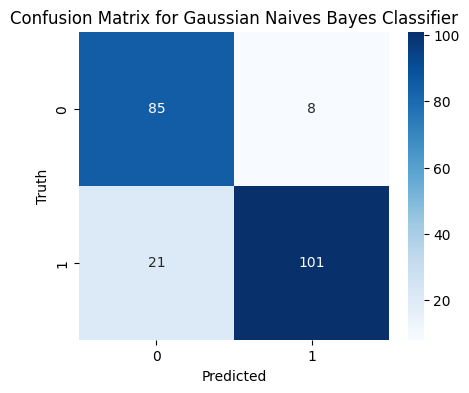

In [41]:
y_predicted = GaussianNaivesBayes.predict(x_test)
cm = confusion_matrix(y_test, y_predicted)

%matplotlib inline
plt.figure(figsize=(5,4))
sn.heatmap(cm, annot=True, cmap='Blues', fmt="d")
plt.title('Confusion Matrix for Gaussian Naives Bayes Classifier')
plt.xlabel('Predicted')
plt.ylabel('Truth')

##### Multinomial Naives Bayes

In [42]:
MultinomialNaivesBayes = MultinomialNB()
MultinomialNaivesBayes.fit(x_train, y_train)

mnb_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]  
}

mnb_grid_result = test_model(MultinomialNaivesBayes, mnb_param_grid)

results['MultinomialNaivesBayes'] = mnb_grid_result

Best: 0.872827 using {'alpha': 2.0}
0.870488 (0.012911) with: {'alpha': 0.001}
0.870488 (0.012911) with: {'alpha': 0.01}
0.870488 (0.012911) with: {'alpha': 0.1}
0.871658 (0.012116) with: {'alpha': 0.5}
0.871658 (0.012116) with: {'alpha': 1.0}
0.872827 (0.014362) with: {'alpha': 2.0}
0.870502 (0.016894) with: {'alpha': 5.0}
0.869325 (0.015795) with: {'alpha': 10.0}


Text(33.22222222222222, 0.5, 'Truth')

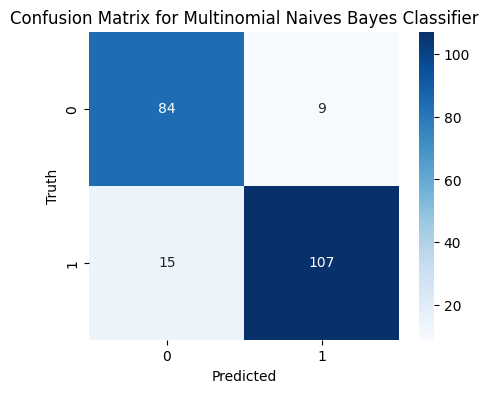

In [43]:
y_predicted = MultinomialNaivesBayes.predict(x_test)
cm = confusion_matrix(y_test, y_predicted)

%matplotlib inline
plt.figure(figsize=(5,4))
sn.heatmap(cm, annot=True, cmap='Blues', fmt="d")
plt.title('Confusion Matrix for Multinomial Naives Bayes Classifier')
plt.xlabel('Predicted')
plt.ylabel('Truth')

##### Bernoulli Naives Bayes 

In [44]:
BernoulliNaivesBayes = BernoulliNB()
BernoulliNaivesBayes.fit(x_train, y_train)

bnb_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]  
}

bnb_grid_result = test_model(BernoulliNaivesBayes, bnb_param_grid)

results['BernoulliNaivesBayes'] = bnb_grid_result

Best: 0.870502 using {'alpha': 0.001}
0.870502 (0.015209) with: {'alpha': 0.001}
0.870502 (0.015209) with: {'alpha': 0.01}
0.870502 (0.015209) with: {'alpha': 0.1}
0.870502 (0.015209) with: {'alpha': 0.5}
0.870495 (0.015273) with: {'alpha': 1.0}
0.870488 (0.012911) with: {'alpha': 2.0}
0.868149 (0.015469) with: {'alpha': 5.0}
0.863498 (0.016601) with: {'alpha': 10.0}


Text(33.22222222222222, 0.5, 'Truth')

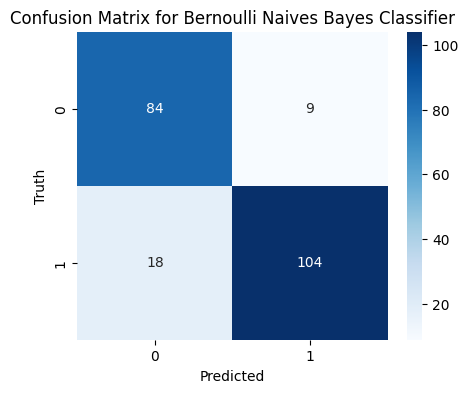

In [45]:
y_predicted = BernoulliNaivesBayes.predict(x_test)
cm = confusion_matrix(y_test, y_predicted)

%matplotlib inline
plt.figure(figsize=(5,4))
sn.heatmap(cm, annot=True, cmap='Blues', fmt="d")
plt.title('Confusion Matrix for Bernoulli Naives Bayes Classifier')
plt.xlabel('Predicted')
plt.ylabel('Truth')